### Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

For further details of the problem look as the pdf.

In [429]:
import pandas as pd
import json
import numpy as np
from datetime import datetime,timedelta

import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("husl")
%matplotlib inline

In [180]:
with open('ultimate_data_challenge.json', encoding='utf-8') as data_file:
    data = json.loads(data_file.read())

In [181]:
type(data), type(data[0])

(list, dict)

In [182]:
data_df = pd.DataFrame(data)

In [183]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [184]:
data_df.signup_date  = [pd.to_datetime(item) for item in data_df.signup_date]

In [185]:
data_df.last_trip_date = [pd.to_datetime(item) for item in data_df.last_trip_date]

In [186]:
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [187]:
# analyze last trip date and later calculate active users
last_trip = [item.date() for item in data_df.last_trip_date]

In [188]:
data_df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [189]:
d = pd.DataFrame(last_trip,columns=["day"])

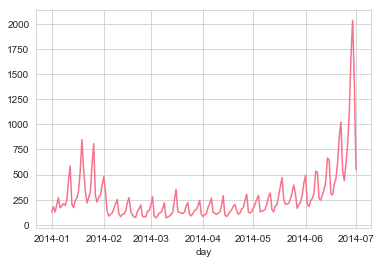

In [190]:
d.groupby(by="day").size().plot()

<div class="alert alert-success">
From about we can see that there quite a good number of active users (who have used the service in the last 30 days). Later we will formally calculate the active users. For now let us fill up the null values for ratings.
<br>
<br>
Let us first fill up the null values. For the column with limited number of ordinal values we can use the most frequently occuring value. Here "avg_rating_by_driver" and "avg_rating_of_driver" are two such columns.
</div>

In [191]:
rating_by_df = data_df.groupby(by="avg_rating_by_driver")["avg_rating_by_driver"].count()

In [192]:
rating_by_df.index

Float64Index([1.0, 1.5, 2.0, 2.3, 2.5, 2.7, 2.8, 3.0, 3.2, 3.3, 3.4, 3.5, 3.6,
              3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9,
              5.0],
             dtype='float64', name='avg_rating_by_driver')

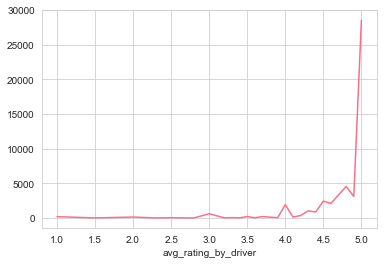

In [193]:
rating_by_df.plot()

In [194]:
np.mean(data_df.avg_rating_by_driver)

4.778158195947439

In [195]:
Counter(data_df.avg_rating_by_driver).most_common(1)

[(5.0, 28508)]

<div class="alert alert-success">
We can fill up nan for avg_rating_by_driver to 5s because both mean and mode points towards that.
</div>

In [196]:
rating_of_df = data_df.groupby(by="avg_rating_of_driver")["avg_rating_of_driver"].count()

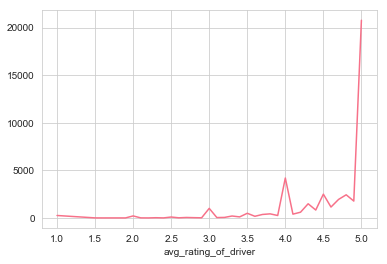

In [197]:
rating_of_df.plot()

In [198]:
np.mean(data_df.avg_rating_of_driver)

4.6015592912744685

In [199]:
Counter(data_df.avg_rating_of_driver).most_common(1)

[(5.0, 20771)]

<div class="alert alert-success">
We can fill up nan for avg_rating_of_driver to 5s because both mean and mode points towards that.
</div>

In [200]:
data_df.avg_rating_by_driver.fillna(5,inplace=True)

In [201]:
data_df.avg_rating_of_driver.fillna(5,inplace=True)

<div class="alert alert-success">
For missing values of phone we can just put the string "None" indicating that phone type is not provided.
</div>

In [206]:
data_df.phone.fillna("None",inplace=True)

In [207]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


<div class="alert alert-success">
Now let us calculate the active users. A user is active if he/she has used the service in the last 30 days.
<br><br>
Here the current date can be taken as the max of last_trip_date. That is when we do the analysis. Note that it is not the value when we are running the report.
</div>

In [208]:
current_date = data_df.last_trip_date.max()

In [209]:
current_date

Timestamp('2014-07-01 00:00:00')

In [210]:
# calculate active user column by checking last trip date
# if it is within last 30 days, the user is active
days30_ago = datetime.strptime('2014-06-01',"%Y-%m-%d")
data_df["active_user"] = [int(item >= days30_ago) for item in data_df.last_trip_date]

In [565]:
# can also use timedelta to find active users, the result is similar
(data_df.last_trip_date >= current_date - timedelta(30)).sum()

18804

In [212]:
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [213]:
data_df.active_user.sum(),data_df.shape

(18804, (50000, 13))

<div class="alert alert-success">
Number of active users is <b>18804</b> out of total of 50,000 users. Or <b>37%</b> of the users are active at the end of the 6th month from the date they singed up for the service
</div>

### Now let us explore and visualize the data to gain insight how an active user looks like

In [214]:
# before anything we should remove the class imbalance so that we do the correct visualizations
data_df[data_df.active_user==1].shape,data_df[data_df.active_user==0].shape

((18804, 13), (31196, 13))

In [215]:
inactive_sample = data_df[data_df.active_user==0].sample(n=18804,random_state=42)

In [216]:
# save original data before balancing class for visualizing data
original_df = data_df.copy()
data_df = data_df[data_df.active_user==1].append(inactive_sample)

In [217]:
data_df.shape

(37608, 13)

In [171]:
data_df.reset_index(inplace=True)

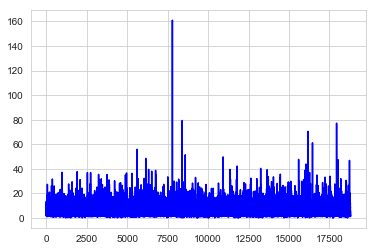

In [172]:
data_df[data_df.active_user==1]['avg_dist'].plot(color='blue')

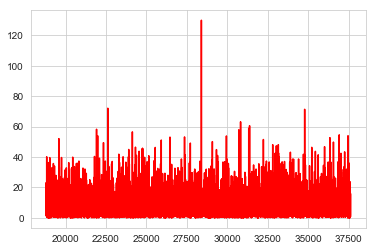

In [173]:
data_df[data_df.active_user==0]['avg_dist'].plot(color='red')

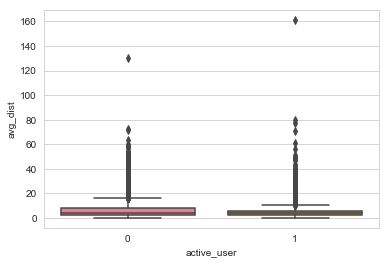

In [174]:
sns.boxplot(x="active_user", y="avg_dist",data=data_df)

In [112]:
s1 = data_df[data_df.active_user==0].sample(n=500,random_state=42)
s2 = data_df[data_df.active_user==1].sample(n=500,random_state=42)
sample = s1.append(s2)

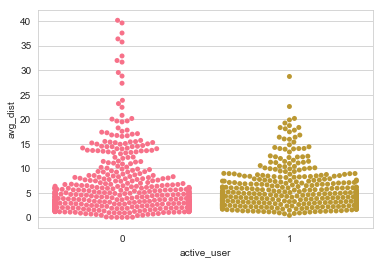

In [113]:
sns.swarmplot(x="active_user", y="avg_dist",data=sample)

<div class="alert alert-success">
From the above charts we see that in general the active users have less avg_dist than the remaining users. It might look paradoxical but if we think it is reasonable. People who are active are using the services on regularly basis as opposed to the ones who take it for limited time but for far distances.
</div>

In [175]:
data_df.describe()

,index,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,active_user
count,37608.000000,37608.000000,37608.000000,37608.000000,37608.000000,37608.000000,37608.000000,37608.000000,37608.000000
mean,24943.703494,5.670667,4.777688,4.658658,1.075253,8.956600,2.482344,60.870831,0.500000
std,14403.945454,5.506903,0.421368,0.575550,0.216582,19.288433,4.069412,35.720519,0.500007
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,12480.750000,2.470000,4.700000,4.500000,1.000000,0.000000,0.000000,35.700000,0.000000
50%,24904.000000,3.850000,5.000000,5.000000,1.000000,0.000000,1.000000,66.700000,0.500000
75%,37394.250000,6.710000,5.000000,5.000000,1.060000,10.000000,3.000000,100.000000,1.000000
max,49999.000000,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000


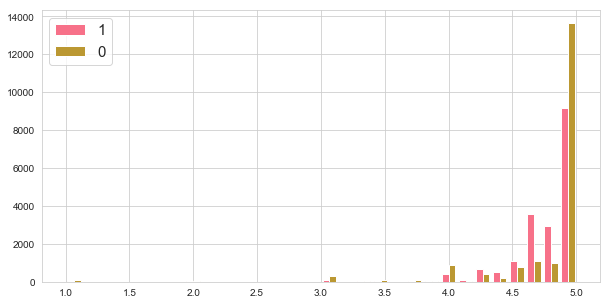

In [118]:
def plot_hist(col):
    fig,ax = plt.subplots(figsize=(10,5))

    active = data_df[data_df.active_user==1][col]
    inactive = data_df[data_df.active_user==0][col]

    ax.hist([active,inactive], 30,  histtype='bar', label=data_df.active_user.unique())
    ax.legend(prop={'size': 15})

plot_hist("avg_rating_by_driver")

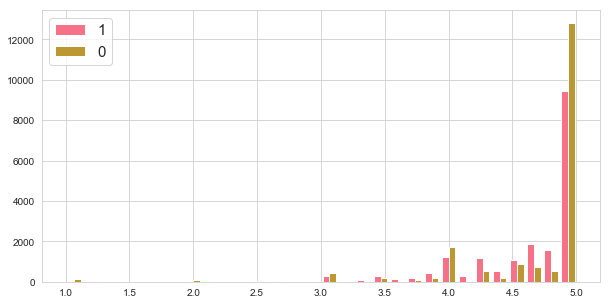

In [119]:
plot_hist("avg_rating_of_driver")

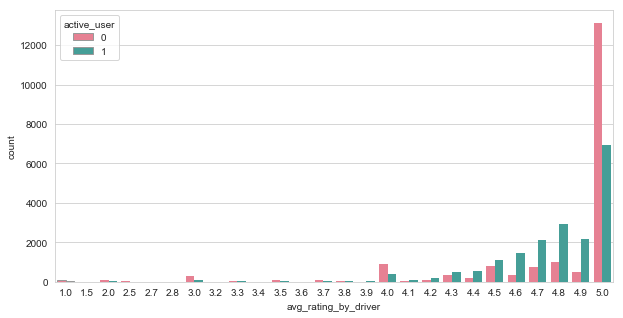

In [121]:
plt.figure(figsize=(10,5))
sns.countplot(x="avg_rating_by_driver", hue="active_user",
            palette="husl", edgecolor=".6",
            data=data_df);

In [122]:
data_df.avg_rating_of_driver.unique()

array([4.7, 4.6, 3.5, 4. , 5. , 3.9, 4.9, 4.4, 4.8, 3.7, 4.1, 4.3, 4.2,
       3. , 3.8, 4.5, 2. , 3.3, 3.6, 2.5, 1. , 2.7, 3.4, 3.2, 3.1, 2.9,
       2.8, 1.9, 2.1, 2.6, 2.3, 2.4, 1.5, 1.6, 2.2, 1.7, 1.8])

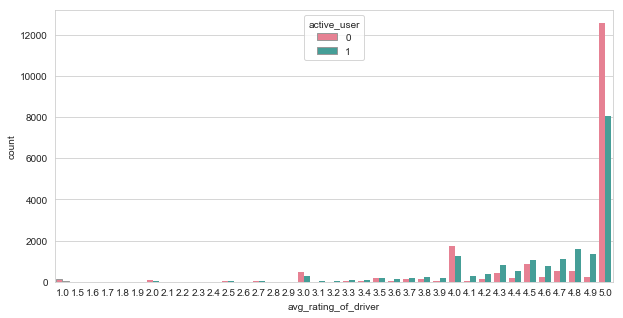

In [123]:
plt.figure(figsize=(10,5))
sns.countplot(x="avg_rating_of_driver", hue="active_user",
            palette="husl", edgecolor=".6",
            data=data_df);

<div class="alert alert-success">
We see that active users tend to give ratings 5 lesser number of times and their own ratings are not 5's as many times as compared to the inactive users.
</div>

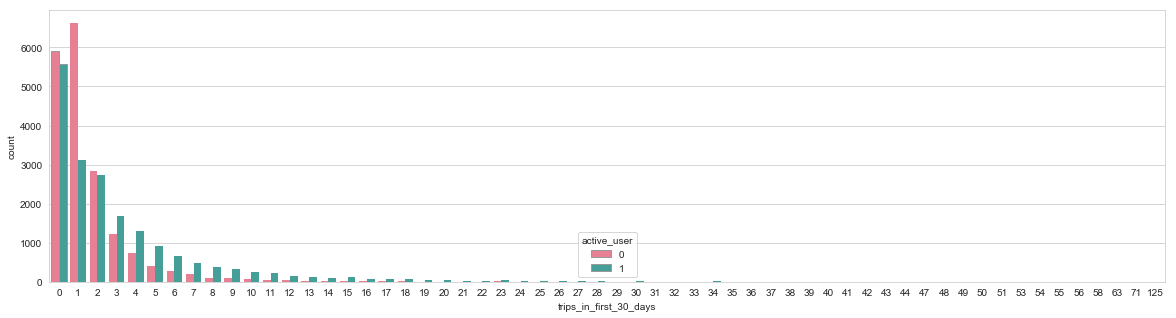

In [124]:
plt.figure(figsize=(20,5))
sns.countplot(x="trips_in_first_30_days", hue="active_user",
            palette="husl", edgecolor=".6",
            data=data_df);

<div class="alert alert-success">
The active users take lot of trips in the first 30 days as compared to the other group.
</div>

In [125]:
data_df.city.unique()

array(["King's Landing", 'Winterfell', 'Astapor'], dtype=object)

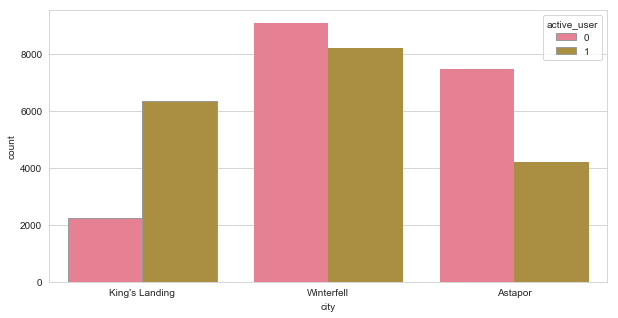

In [127]:
plt.figure(figsize=(10,5))
sns.countplot(x="city", hue="active_user",
             edgecolor=".6",
            data=data_df);

<div class="alert alert-success">
The proportion of active users in King's Landing is relatively huge as compared to other cities. This might serve as good feature.
</div>

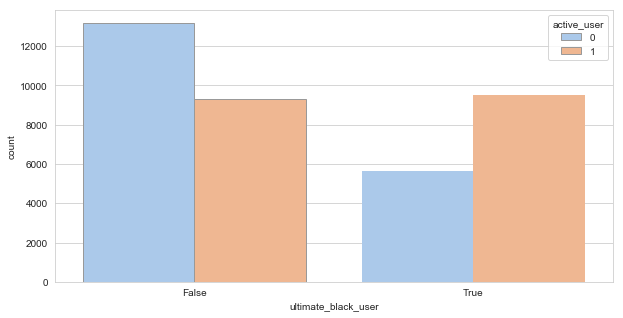

In [91]:
plt.figure(figsize=(10,5))
sns.countplot(x="ultimate_black_user", hue="active_user",
            palette="pastel", edgecolor=".6",
            data=data_df);

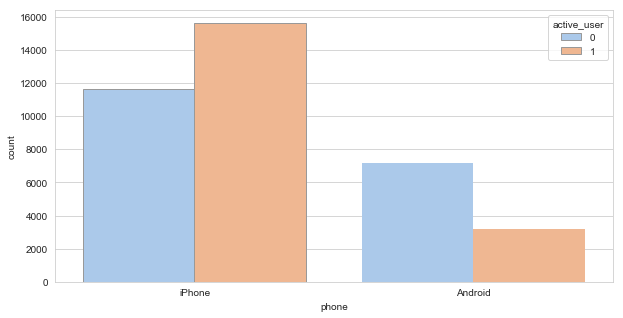

In [92]:
plt.figure(figsize=(10,5))
sns.countplot(x="phone", hue="active_user",
            palette="pastel", edgecolor=".6",
            data=data_df);

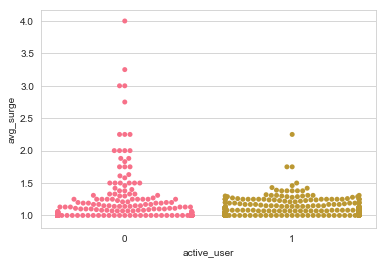

In [93]:
sns.swarmplot(x="active_user", y="avg_surge",data=sample)

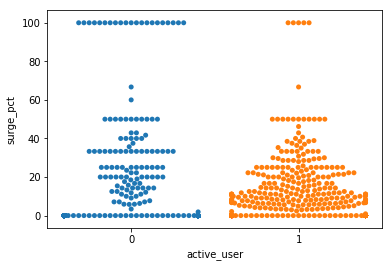

In [435]:
sns.swarmplot(x="active_user", y="surge_pct",data=sample)
plt.show()

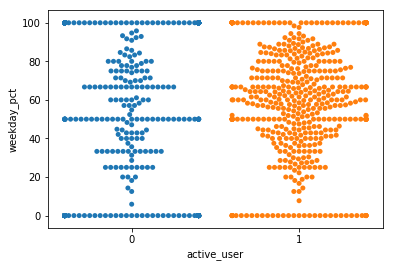

In [436]:
sns.swarmplot(x="active_user", y="weekday_pct",data=sample)
plt.show()

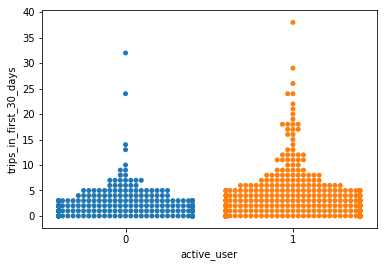

In [437]:
sns.swarmplot(x="active_user", y="trips_in_first_30_days",data=sample)
plt.show()

<div class="alert alert-success">
We shall now on to move to prediction. For that we need to build our feature columns. Mainly the 2 date fields need to be converted to timestamp. We are continue with our down sample. Later we should see if get better results with different class balancing techniques.
</div>

In [218]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active_user               50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


In [288]:
labelEncoder = LabelEncoder()

city_encoded = labelEncoder.fit_transform(original_df.city)
city_encoded = city_encoded.reshape(len(original_df),1)

hotEncoder = OneHotEncoder(sparse=False)

onehot_encoded = hotEncoder.fit_transform(city_encoded)

city_df = pd.DataFrame(onehot_encoded,columns=labelEncoder.classes_,dtype='int64')

In [287]:
phone_encoded = labelEncoder.fit_transform(original_df.phone.astype(str))
phone_encoded = phone_encoded.reshape(len(phone_encoded),1)
onehot_encoded = hotEncoder.fit_transform(phone_encoded)
phone_df = pd.DataFrame(onehot_encoded,columns=labelEncoder.classes_,dtype='int64')

In [290]:
feature_df = original_df.copy()

In [291]:
city_df.head(), city_df.columns

(   Astapor  King's Landing  Winterfell
 0        0               1           0
 1        1               0           0
 2        1               0           0
 3        0               1           0
 4        0               0           1,
 Index(['Astapor', 'King's Landing', 'Winterfell'], dtype='object'))

In [292]:
phone_df.head()

,Android,None,iPhone
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,1,0,0


In [293]:
feature_df.signup_date = [item.timestamp() for item in  feature_df.signup_date]

In [294]:
feature_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,1.390608e+09,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,1.390954e+09,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,1.388966e+09,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,1.389312e+09,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,1.390781e+09,11.8,14,False,82.4,0


In [295]:
feature_df.ultimate_black_user = [int(item) for item in feature_df.ultimate_black_user]

<div class="alert alert-success">
Removing column "last_trip_date" because this was used in calculating active/inactive user. If we don't do that then our models will perform perfect. But that doesn't make sense.
</div>

In [324]:
# removing because this column was used in calculating active/inactive user
feature_df.drop(['last_trip_date'],axis=1,inplace=True)

In [297]:
feature_df.index = np.arange(0,len(feature_df.index))

In [298]:
feature_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,1.390608e+09,15.4,4,1,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,1.390954e+09,0.0,0,0,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,1.388966e+09,0.0,3,0,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,1.389312e+09,20.0,9,1,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,1.390781e+09,11.8,14,0,82.4,0


In [301]:
feature_df = feature_df.join(city_df)

In [302]:
feature_df = feature_df.join(phone_df)

In [303]:
feature_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user,Astapor,King's Landing,Winterfell,Android,None,iPhone
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,1.390608e+09,15.4,4,1,46.2,1,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,1.390954e+09,0.0,0,0,50.0,0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,1.388966e+09,0.0,3,0,100.0,0,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,1.389312e+09,20.0,9,1,80.0,1,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,1.390781e+09,11.8,14,0,82.4,0,0,0,1,1,0,0


In [304]:
feature_df.drop(['city','phone'],axis=1,inplace=True)

In [305]:
feature_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user,Astapor,King's Landing,Winterfell,Android,None,iPhone
0,3.67,5.0,4.7,1.10,2014-06-17,1.390608e+09,15.4,4,1,46.2,1,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,1.390954e+09,0.0,0,0,50.0,0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,1.388966e+09,0.0,3,0,100.0,0,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,1.389312e+09,20.0,9,1,80.0,1,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,1.390781e+09,11.8,14,0,82.4,0,0,0,1,1,0,0


In [307]:
feature_df.last_trip_date = [item.timestamp() for item in  feature_df.last_trip_date]

<div class="alert alert-success">
Final list of features going to be used for modeling.
</div>

In [325]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 16 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
signup_date               50000 non-null float64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
active_user               50000 non-null int64
Astapor                   50000 non-null int64
King's Landing            50000 non-null int64
Winterfell                50000 non-null int64
Android                   50000 non-null int64
None                      50000 non-null int64
iPhone                    50000 non-null int64
dtypes: float64(7), int64(9)
memory usage: 7.7 MB


In [326]:
X = feature_df.drop(['active_user'],axis=1)

In [327]:
y = feature_df.active_user

In [567]:
# train and test(20%) set from all data 
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [329]:
X_train.shape, y_train.shape,y_test.shape

((40000, 15), (40000,), (10000,))

In [417]:
# class prior because our classes are imbalance, the percentage of active users in only 37%. Hence the class_prior.
mnb = MultinomialNB(class_prior=[0.7,0.3])

In [418]:
mnb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=[0.7, 0.3], fit_prior=True)

In [419]:
y_pred = mnb.predict(X_test)

In [420]:
y_pred.sum()

2789

In [421]:
accuracy_score(y_pred=y_pred,y_true=y_test)

0.6544

In [422]:
mnb.score(X_train,y_train)

0.663075

<div class="alert alert-success">
This is our base model accuracy. We will use other classifiers to get best model.
</div>

In [423]:
print(classification_report(y_true=y_test,y_pred=y_pred))

             precision    recall  f1-score   support

          0       0.69      0.80      0.74      6219
          1       0.56      0.41      0.47      3781

avg / total       0.64      0.65      0.64     10000



In [424]:
print(confusion_matrix(y_true=y_test,y_pred=y_pred,labels=[0,1]))

[[4987 1232]
 [2224 1557]]


In [397]:
# Random forest classifier
# again class weights are given opposite to the class imbalance to compensate
# max features should be square root of all features approximately
rfc = RandomForestClassifier(n_estimators=1000,max_features=4,class_weight={0:.37,1:.63})
rfc = rfc.fit(X_train,y_train) 

In [398]:
rfc.score(X_test,y_test)

0.7684

In [399]:
rfc.score(X_train,y_train)

0.9999

In [392]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0:.37,1:.63}))

In [393]:
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight={0: 0.37, 1: 0.63}, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [394]:
ada.score(X_test,y_test)

0.7186

In [395]:
ada.score(X_train,y_train)

0.9999

In [396]:
gbs = GradientBoostingClassifier(n_estimators=100)

In [495]:
gbs.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [367]:
gbs.score(X_test,y_test)

0.7837

In [368]:
gbs.score(X_train,y_train)

0.790625

<div class="alert alert-success">
This Gradient boost model performed best so far. Let us see what features contribute most.
</div>

In [369]:
gbs.feature_importances_

array([0.10543296, 0.08908134, 0.0563896 , 0.03604949, 0.02043337,
       0.15868729, 0.11964355, 0.06616546, 0.15888034, 0.0451797 ,
       0.0733242 , 0.00076938, 0.04092596, 0.00049226, 0.0285451 ])

In [375]:
print(list(zip(X_train.columns, gbs.feature_importances_)))

[('avg_dist', 0.10543296341528471), ('avg_rating_by_driver', 0.08908133808544917), ('avg_rating_of_driver', 0.05638960420388815), ('avg_surge', 0.0360494862272616), ('signup_date', 0.020433371446559226), ('surge_pct', 0.15868728505917118), ('trips_in_first_30_days', 0.11964355025343645), ('ultimate_black_user', 0.06616546411243754), ('weekday_pct', 0.15888034209701093), ('Astapor', 0.04517970009988634), ("King's Landing", 0.07332419585790545), ('Winterfell', 0.0007693833515503612), ('Android', 0.04092595611514345), ('None', 0.0004922621511929436), ('iPhone', 0.028545097523822446)]


In [449]:
# taking too much time
param_grid = {'learning_rate':[0.03,0.1,0.3], 'max_depth':[3,None], \
              'max_features':[4,5], 'n_estimators':[100,200],'random_state':[42]}

In [450]:
param_grid = {'max_depth':[3,None], \
              'max_features':[4,5], 'n_estimators':[100],'random_state':[42]}

In [441]:
gbs2 = GradientBoostingClassifier()

In [442]:
gcv_gbs = GridSearchCV(gbs, cv=5, param_grid=param_grid, scoring="accuracy", return_train_score=True)

In [443]:
gcv_gbs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [4, 5], 'n_estimators': [100], 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [445]:
gbs_best = gcv_gbs.best_estimator_

In [446]:
gbs_best.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [447]:
gbs_best.score(X_train,y_train)

0.78845

In [448]:
gbs_best.score(X_test,y_test)

0.7835

<div class="alert alert-success">
Going to compare all the models to find out the best that can be used in future for predictions of active users.
</div>

In [547]:
score_table = pd.DataFrame(columns=["train-score", "test-score", "classifier-type","params"])

In [548]:
def add_score(cls_name,cls,cls_type,X_tr=X_train,X_tes=X_test):
    score_table.loc[cls_name,"train-score"] = cls.score(X_tr,y_train)
    score_table.loc[cls_name,"test-score"] = cls.score(X_tes,y_test)
    score_table.loc[cls_name,"classifier-type"] = cls_type
    score_table.loc[cls_name,"params"] = cls
    
add_score("mnb", mnb,"Naive Bayes")    

In [549]:
add_score("rfc",rfc,"Random Forest")

In [550]:
add_score("ada",ada,"Ada Boost")

In [551]:
add_score("gbs",gbs, "Gradient Boost")

In [552]:
add_score("gbs_best",gbs_best, "Gradient Boost best params")

In [553]:
score_table.head()

,train-score,test-score,classifier-type,params
mnb,0.663075,0.6544,Naive Bayes,"MultinomialNB(alpha=1.0, class_prior=[0.7, 0.3..."
rfc,0.9999,0.7684,Random Forest,"(DecisionTreeClassifier(class_weight=None, cri..."
ada,0.9999,0.7186,Ada Boost,"(DecisionTreeClassifier(class_weight={0: 0.37,..."
gbs,0.790625,0.7837,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...
gbs_best,0.78845,0.7835,Gradient Boost best params,([DecisionTreeRegressor(criterion='friedman_ms...


<div class="alert alert-success">
Gradient Boost models seem to be the best. Let us also try removing some features that don't contribute much and see the model performance.
</div>

In [500]:
features = list(zip(X_train.columns, gbs.feature_importances_))

In [508]:
features.sort(key=lambda x:x[1],reverse=True)

In [509]:
features

[('weekday_pct', 0.1589124729760156),
 ('surge_pct', 0.15868728505907578),
 ('trips_in_first_30_days', 0.11964355025347401),
 ('avg_dist', 0.10543296341541336),
 ('avg_rating_by_driver', 0.08908133808551388),
 ("King's Landing", 0.07332419585784698),
 ('ultimate_black_user', 0.06618805379229807),
 ('avg_rating_of_driver', 0.05636701452393591),
 ('Astapor', 0.04517970009964196),
 ('Android', 0.04092595611513079),
 ('avg_surge', 0.03601735534849825),
 ('iPhone', 0.02854509752381996),
 ('signup_date', 0.020433371446591207),
 ('Winterfell', 0.0007693833515503993),
 ('None', 0.0004922621511937686)]

In [543]:
# taking top 5 features only
X_train_2 = X_train.drop(["avg_surge","iPhone","signup_date","Winterfell","None"],axis=1)

In [544]:
X_test_2 = X_test.drop(["avg_surge","iPhone","signup_date","Winterfell","None"],axis=1)

In [545]:
gcv_gbs = GridSearchCV(GradientBoostingClassifier(), cv=5, param_grid=param_grid, scoring="accuracy", return_train_score=True)

In [546]:
gcv_gbs.fit(X_train_2,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [4, 5], 'n_estimators': [100], 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [556]:
gbs_less = gcv_gbs.best_estimator_

In [557]:
add_score("gbs_less",gcv_gbs.best_estimator_, "Gradient Boost less features" \
          ,X_tr=X_train_2,X_tes=X_test_2)

In [563]:
gbs_less.score(X_train_2,y_train)

0.789025

In [571]:
y_pred = gbs_less.predict(X_test_2)

In [572]:
print(classification_report(y_true=y_test,y_pred=y_pred))

             precision    recall  f1-score   support

          0       0.81      0.85      0.83      6219
          1       0.73      0.67      0.70      3781

avg / total       0.78      0.78      0.78     10000



In [568]:
# the model with less features is not so bad. So we can keep that for simplicity.
score_table

,train-score,test-score,classifier-type,params
mnb,0.663075,0.6544,Naive Bayes,"MultinomialNB(alpha=1.0, class_prior=[0.7, 0.3..."
rfc,0.9999,0.7684,Random Forest,"(DecisionTreeClassifier(class_weight=None, cri..."
ada,0.9999,0.7186,Ada Boost,"(DecisionTreeClassifier(class_weight={0: 0.37,..."
gbs,0.790625,0.7837,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...
gbs_best,0.78845,0.7835,Gradient Boost best params,([DecisionTreeRegressor(criterion='friedman_ms...
gbs_less,0.789025,0.7821,Gradient Boost less features,([DecisionTreeRegressor(criterion='friedman_ms...


In [576]:
# how do I find if a feature is directly or inversely affecting the output

### Conclusion

First we found out the active users based on the definition given that the users who used the service within the last 30 days. The number of active users came out to be only 37%. Meaning all other users get less active after joining. And these 37% are the regular users who generate big part of consistent revenue.


We filled up some of the null values for the driver and user ratings by applying statistical knowledge. We use the most frequently occuring values. For the absent phone types we just put value "None", because that might serve some kind of insight. Not having phone in system might mean something regarding user's being active or inactive.


We visualized various features with respect to active/inactive and gained some insights. For example, city "King's Landing" suggests strongly in favor of user being active. Similarly other data like surge_pct, trips_in_first_30_days are important decisive factors.

Having ground understanding of the data we moved on to developing our models and use the given data to predict a user being active or not. We did cross validation and found the best params to be use for our models. We applied Boosting models that uses a large number of weak classifiers that are very different from each other.

We also found important features and removed the less important ones. The resulting model was nearly as good as the ones using all the features. But lesser the number of features the less complex our model would be. 

So in the end we can keep the Gradient Boost model with only top 7 features i.e.
<b>
'weekday_pct', 'surge_pct', 'trips_in_first_30_days', 'avg_dist', 'avg_rating_by_driver', "King's Landing", 'ultimate_black_user', 'avg_rating_of_driver', 'Astapor', 'Android'
</b>


This model provides accuracy of 0.78 for the test data. The f1-score is 70%. So for future data of users we can accurately predict if he/she is active as many as 78% times.


To improve the rider retention:
- We may pay more attention to weekday service as compared to weekends. Proabably it means that weekday trips are more important for a user to become at active user. It makes sense, because users use weekday service more regularly then weekends, which may be more irregular.

- We might pay special attention to riders who have higher surge_pct.

- avg_rating_by_driver is also important. So drivers may be cautioned regarding the rating they give to the riders.

- And further investigation should be made as how "King's Landing" city is different from others.
